# Using NN for Feature Extraction

Using a pre-trained model for feature extraction, into downstream UMAP.

*Aniket Pant, Personal*

In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms, models
import os
import numpy as np
from sklearn import preprocessing
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import umap

# Setting device for GPU usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [25]:
device

device(type='cuda')

In [26]:
# Define your own CNN or use a pre-trained model
model = models.resnet50(pretrained=True)
model = model.to(device)
model.fc = nn.Sequential()

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 111MB/s]


In [27]:
# Prepare Dataset
data_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

# Define indices
indices = np.random.choice(np.arange(81001), size=5000, replace=False)

# Create ImageFolder and Subset
image_datasets = datasets.ImageFolder('./wikiart', data_transform)
subset_datasets = Subset(image_datasets, indices)

# Get filenames from the ImageFolder using Subset indices
filenames = [image_datasets.imgs[i][0] for i in subset_datasets.indices]

In [28]:
dataloaders = DataLoader(subset_datasets, batch_size=16, shuffle=True, num_workers=4)

In [29]:
dataset_sizes = len(image_datasets)
print(dataset_sizes)

81448


In [30]:
# Extract features using CNN
def extract_features(loader):
    features = []
    labels = []

    with torch.no_grad():
        for i, (inputs, classes) in tqdm(enumerate(loader)):
            inputs = inputs.to(device)
            outputs = model(inputs)
            features.extend(outputs.cpu().numpy())
            labels.extend(classes.cpu().numpy())
    return features, labels

In [31]:
features, labels = extract_features(dataloaders)

313it [02:38,  1.98it/s]


In [32]:
def plot_embeddings(embeddings, labels):
    plt.figure(figsize=(6, 4))

    le = preprocessing.LabelEncoder()
    classes = le.fit_transform(labels)

    # Create a scatter plot
    plt.scatter(embeddings[:, 0], embeddings[:, 1], c = classes, s = 1, alpha = 0.3)

    plt.colorbar()
    plt.axis("off")
    plt.show()

In [33]:
# Use UMAP to reduce dimensionality
reducer = umap.UMAP()
embedding = reducer.fit_transform(features)

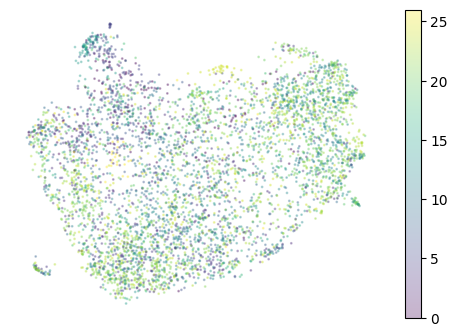

In [34]:
plot_embeddings(embedding, labels)

In [35]:
np.save("embeddings.npy", embedding)
np.save("labels.npy", labels)
np.save("filenames.npy", filenames)